In [1]:
import torch

In [2]:
import triton
import triton.language as tl

In [3]:
@torch.jit.script
def naive_softmax(x):
    x_max = x.max(dim=1)[0]
    z = x - x_max[:, None]
    numerator = torch.exp(z)
    denominator = numerator.sum(dim=1)
    ret = numerator / denominator[:, None]
    return ret

In [4]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_cols, BLOCK_SIZE: tl.constexpr):
    row_idx = tl.program_id(0)

    row_start_ptr = input_ptr + row_idx * input_row_stride
    
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets

    row = tl.load(input_ptrs, mask=col_offsets < n_cols, other=-float('inf'))

    row_minus_max = row - tl.max(row, axis=0)

    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator, axis=0)
    softmax_output = numerator / denominator

    output_row_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=col_offsets < n_cols)

In [5]:
def softmax(x):
    n_rows, n_cols = x.shape

    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 4

    if BLOCK_SIZE >= 2048:
        num_warps = 8

    if BLOCK_SIZE >= 4096:
        num_warps = 16

    y = torch.empty_like(x)

    softmax_kernel[(n_rows, )](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_cols,
        num_warps=num_warps,
        BLOCK_SIZE=BLOCK_SIZE,
    )

    return y

In [6]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device='cuda')
# y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
# assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

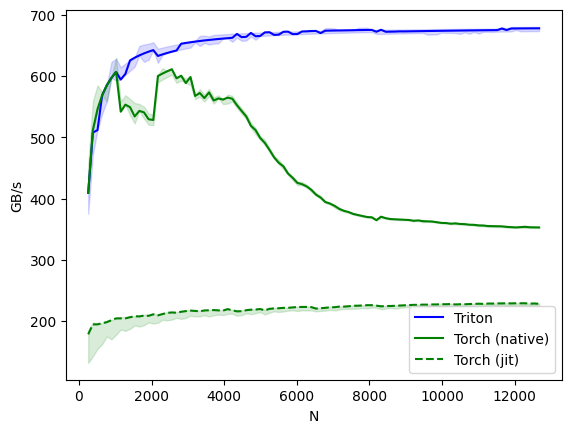

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  409.600010      409.600010   178.815827
1     384.0  508.030998      511.999982   194.950918
2     512.0  512.000001      546.133347   195.047621
3     640.0  568.888869      568.888869   196.923079
4     768.0  585.142862      585.142862   198.593945
..      ...         ...             ...          ...
93  12160.0  677.909402      353.745456   229.433963
94  12288.0  677.958629      354.248663   229.414234
95  12416.0  678.006849      353.480445   228.866366
96  12544.0  678.054025      353.352102   229.114161
97  12672.0  678.100319      353.226478   228.581736

[98 rows x 4 columns]


In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 2048},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)